<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/XGBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', parse_dates = ['date'])

In [4]:
col = ['new_confirmed', 'new_persons_fully_vaccinated',
                                           'new_confirmed_lag1', 'new_confirmed_lag3', 'new_confirmed_lag7',
                                           'new_confirmed_mean7']

In [5]:
# group by countries
train_country = train.groupby(['country_code','date'])
test_country = test.groupby(['country_code','date'])
train_country_agg = train_country.agg('sum')
train_country_agg.reset_index(level = 'country_code', inplace = True)
test_country_agg = test_country.agg('sum')
test_country_agg.reset_index(level = 'country_code', inplace = True)

<ipython-input-5-bc410932a85f>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_country_agg = train_country.agg('sum')
<ipython-input-5-bc410932a85f>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_country_agg = test_country.agg('sum')


In [6]:
train_us = train_country_agg.loc[train_country_agg.country_code == 'US',col]

test_us = test_country_agg.loc[test_country_agg.country_code == 'US',col]


In [8]:
train_us=train_us.iloc[:][col]
test_us=test_us.iloc[: ][col]
print(train_us.shape, test_us.shape)

(719, 6) (258, 6)


In [10]:
model = xgb.XGBRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, n_jobs=-1, random_state=0)
model.fit(train_us.drop('new_confirmed', axis=1), train_us['new_confirmed'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=0, ...)

In [11]:
train_pred=pd.DataFrame(model.predict(train_us.drop('new_confirmed', axis=1)), columns=['yhat'], index=train_us.index)
train_pred.head()

,yhat
date,
2020-01-13,2591.730713
2020-01-14,2591.730713
2020-01-15,2591.730713
2020-01-16,2591.730713
2020-01-17,2591.730713


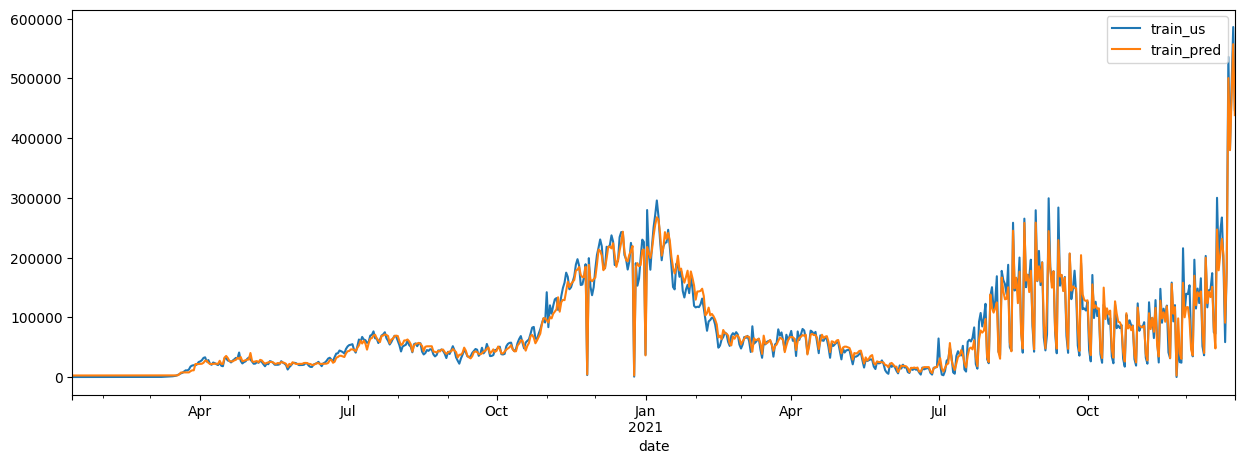

In [12]:
pd.concat([train_us['new_confirmed'],train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train_us', 'train_pred'])

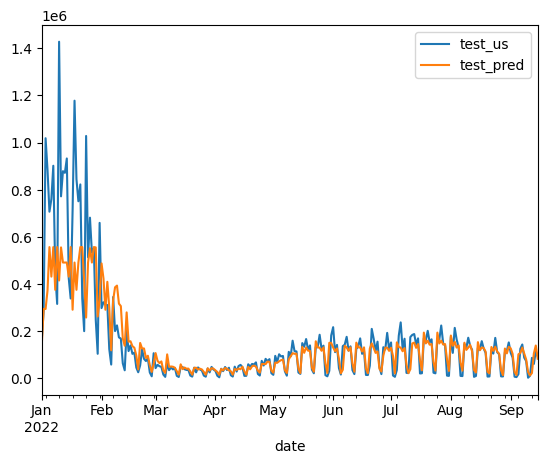

In [13]:
test_pred=pd.DataFrame(model.predict(test_us.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_us.index)
pd.concat([test_us['new_confirmed'],test_pred['yhat']], axis=1).plot( )
plt.legend(['test_us', 'test_pred'])

In [19]:
np.sqrt(mean_squared_error(y_true = test_us['new_confirmed'],
                          y_pred = test_pred['yhat']))

140452.89937413606

In [20]:
mean_absolute_error(y_true = test_us['new_confirmed'],
                    y_pred = test_pred['yhat'])

60755.52197265625

In [21]:
mean_absolute_percentage_error(y_true = test_us['new_confirmed'],
                    y_pred = test_pred['yhat'])

64.21157965805658

In [22]:
# Tuning hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [23]:
params = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
}


In [24]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror')

In [25]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='neg_mean_squared_error',  # Can change to other metrics
    cv=5,  # Number of folds in cross-validation
    verbose=1,  # Higher number gives more information about the process
    n_jobs=-1  # Use all available cores
)

In [26]:
grid_search.fit(train_us.drop('new_confirmed', axis=1), train_us['new_confirmed'])

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_parameters)
print("Best Score:", best_score)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Score: -2185784507.0181713


In [30]:
best_model = grid_search.best_estimator_
predictions=pd.DataFrame(best_model.predict(test_us.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_us.index)


In [31]:
np.sqrt(mean_squared_error(y_true = test_us['new_confirmed'],
                          y_pred = predictions['yhat']))

179577.3748486592

In [32]:
mean_absolute_error(y_true = test_us['new_confirmed'],
                    y_pred = predictions['yhat'])

77957.04664789244

In [33]:
mean_absolute_percentage_error(y_true = test_us['new_confirmed'],
                    y_pred = predictions['yhat'])

95.73258347417709

In [53]:
model2 = xgb.XGBRegressor(learning_rate=1, max_depth=6, n_estimators=200, n_jobs=-1, random_state=0)
model2.fit(train_us.drop('new_confirmed', axis=1), train_us['new_confirmed'])
pred2=pd.DataFrame(model2.predict(test_us.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_us.index)
np.sqrt(mean_squared_error(y_true = test_us['new_confirmed'],
                          y_pred = pred2['yhat']))

119505.35780435841

In [54]:
mean_absolute_error(y_true = test_us['new_confirmed'],
                    y_pred = pred2['yhat'])

60090.72176012143

In [55]:
mean_absolute_percentage_error(y_true = test_us['new_confirmed'],
                    y_pred = pred2['yhat'])

70.50066110899212